In [1]:
import numpy as np
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path
from src.neon_blink_detector import detect_blinks
import typing as T
from helper import OfParams, PPParams, AugParams
from post_processing import post_process
from xgboost import XGBClassifier
from pathlib import Path
import joblib
from features_calculator import calculate_optical_flow, concatenate_features, create_grids
from utils import resize_images, rotate_images

video_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

iclip = 0

clip_names = [
    "2023-03-01_09-59-07-2ea49126",  # kai bike
    "2023-01-27_15-59-54-49a115d5",  # tom computer
    "2023-02-01_11-45-11-7621531e",  # kai computer
    "2023-01-27_16-10-14-a2a8cbe1",  # ryan discussing
    "2023-01-27_16-15-26-57802f75",  # tom walking
    "2023-01-27_16-24-04-eb4305b1",  # kai walking
    "2023-01-27_16-31-52-5f743ed0",  # moritz snowboarding
    "padel_tennis_neon_01-b922b245",  # mgg padel
    "padel_tennis_neon_03-2ded8f56",  # mgg partner padel
]


def get_params() -> T.Tuple[OfParams, PPParams]:
    """Get optical flow parameters and post processing parameters."""

    of_params = OfParams(5, 7, False, (64, 64), 4, 7, 15, 3)
    pp_params = PPParams(
        max_gap_duration_s=0.03,
        short_event_min_len_s=0.1,
        smooth_window=11,
        proba_onset_threshold=0.25,
        proba_offset_threshold=0.25,
    )
    
    aug_params = AugParams()
    return of_params, pp_params

def get_classifier(clf_path: Path) -> XGBClassifier:
    """Get classifier with weights."""

    return joblib.load(str(clf_path))

of_params, pp_params = get_params()
aug_params = AugParams()
of_params.n_layers = 5
of_params.layer_interval = 7
of_params.grid_size = 4
of_params.window_size = 15

clf = get_classifier("/users/tom/git/neon_blink_detection/weights/xgb.sav")

rec = video_loader(of_params, aug_params)
ts, images_left, images_right = rec._get_frames_pyav(clip_names[iclip], convert_to_gray=True)

times = (ts - ts[0]) / 1e9
# times = np.arange(0, len(ts)) / 200.0
blink_df = rec._load_gt_labels(clip_names[iclip])

grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

features = concatenate_features(feature_array, of_params)
proba = clf.predict_proba(features)
blink_events = post_process(ts, proba, pp_params)

from src.utils import resize_images

left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)

blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]


img_left = np.concatenate([left_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])
img_right = np.concatenate([right_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

def compute_iou(event1, event2):
    start1, end1 = event1
    start2, end2 = event2
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    intersection_length = max(0, intersection_end - intersection_start)
    
    union_start = min(start1, start2)
    union_end = max(end1, end2)
    union_length = union_end - union_start

    return intersection_length / union_length

def compute_multiple_iou(ground_truth_events, predicted_events, iou_threshold=0.2):
    ground_truth_indices = set(range(len(ground_truth_events)))
    predicted_indices = set(range(len(predicted_events)))
    iou_results = []
    true_positives = []

    for gt_index, gt_event in enumerate(ground_truth_events):
        for pred_index, pred_event in enumerate(predicted_events):
            iou = compute_iou(gt_event, pred_event)
            if iou > iou_threshold:
                iou_results.append((gt_index, pred_index, iou))
                true_positives.append((pred_index, predicted_events[pred_index]))
                if gt_index in ground_truth_indices:
                    ground_truth_indices.remove(gt_index)
                if pred_index in predicted_indices:
                    predicted_indices.remove(pred_index)

    false_negatives = [(i, ground_truth_events[i]) for i in ground_truth_indices]
    false_positives = [(i, predicted_events[i]) for i in predicted_indices]

    return iou_results, true_positives, false_negatives, false_positives


pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt, pred, iou_threshold=0.2)



/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**CREATE VIDEO OF FALSE POSITIVES**

In [276]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(false_positives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[false_positives[i][1][0]:false_positives[i][1][1],:,:]
    video_right = images_right[false_positives[i][1][0]:false_positives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[false_positives[i][1][0]:false_positives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/FP%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

KeyboardInterrupt: 

**CREATE VIDEO OF FALSE NEGTIVES**

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(false_negatives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]
    video_right = images_right[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[false_negatives[i][1][0]:false_negatives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/FN%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**VIDEOS OF TRUE POSITIVES**

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(true_positives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[true_positives[i][1][0]:true_positives[i][1][1],:,:]
    video_right = images_right[true_positives[i][1][0]:true_positives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[true_positives[i][1][0]:true_positives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/TP%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

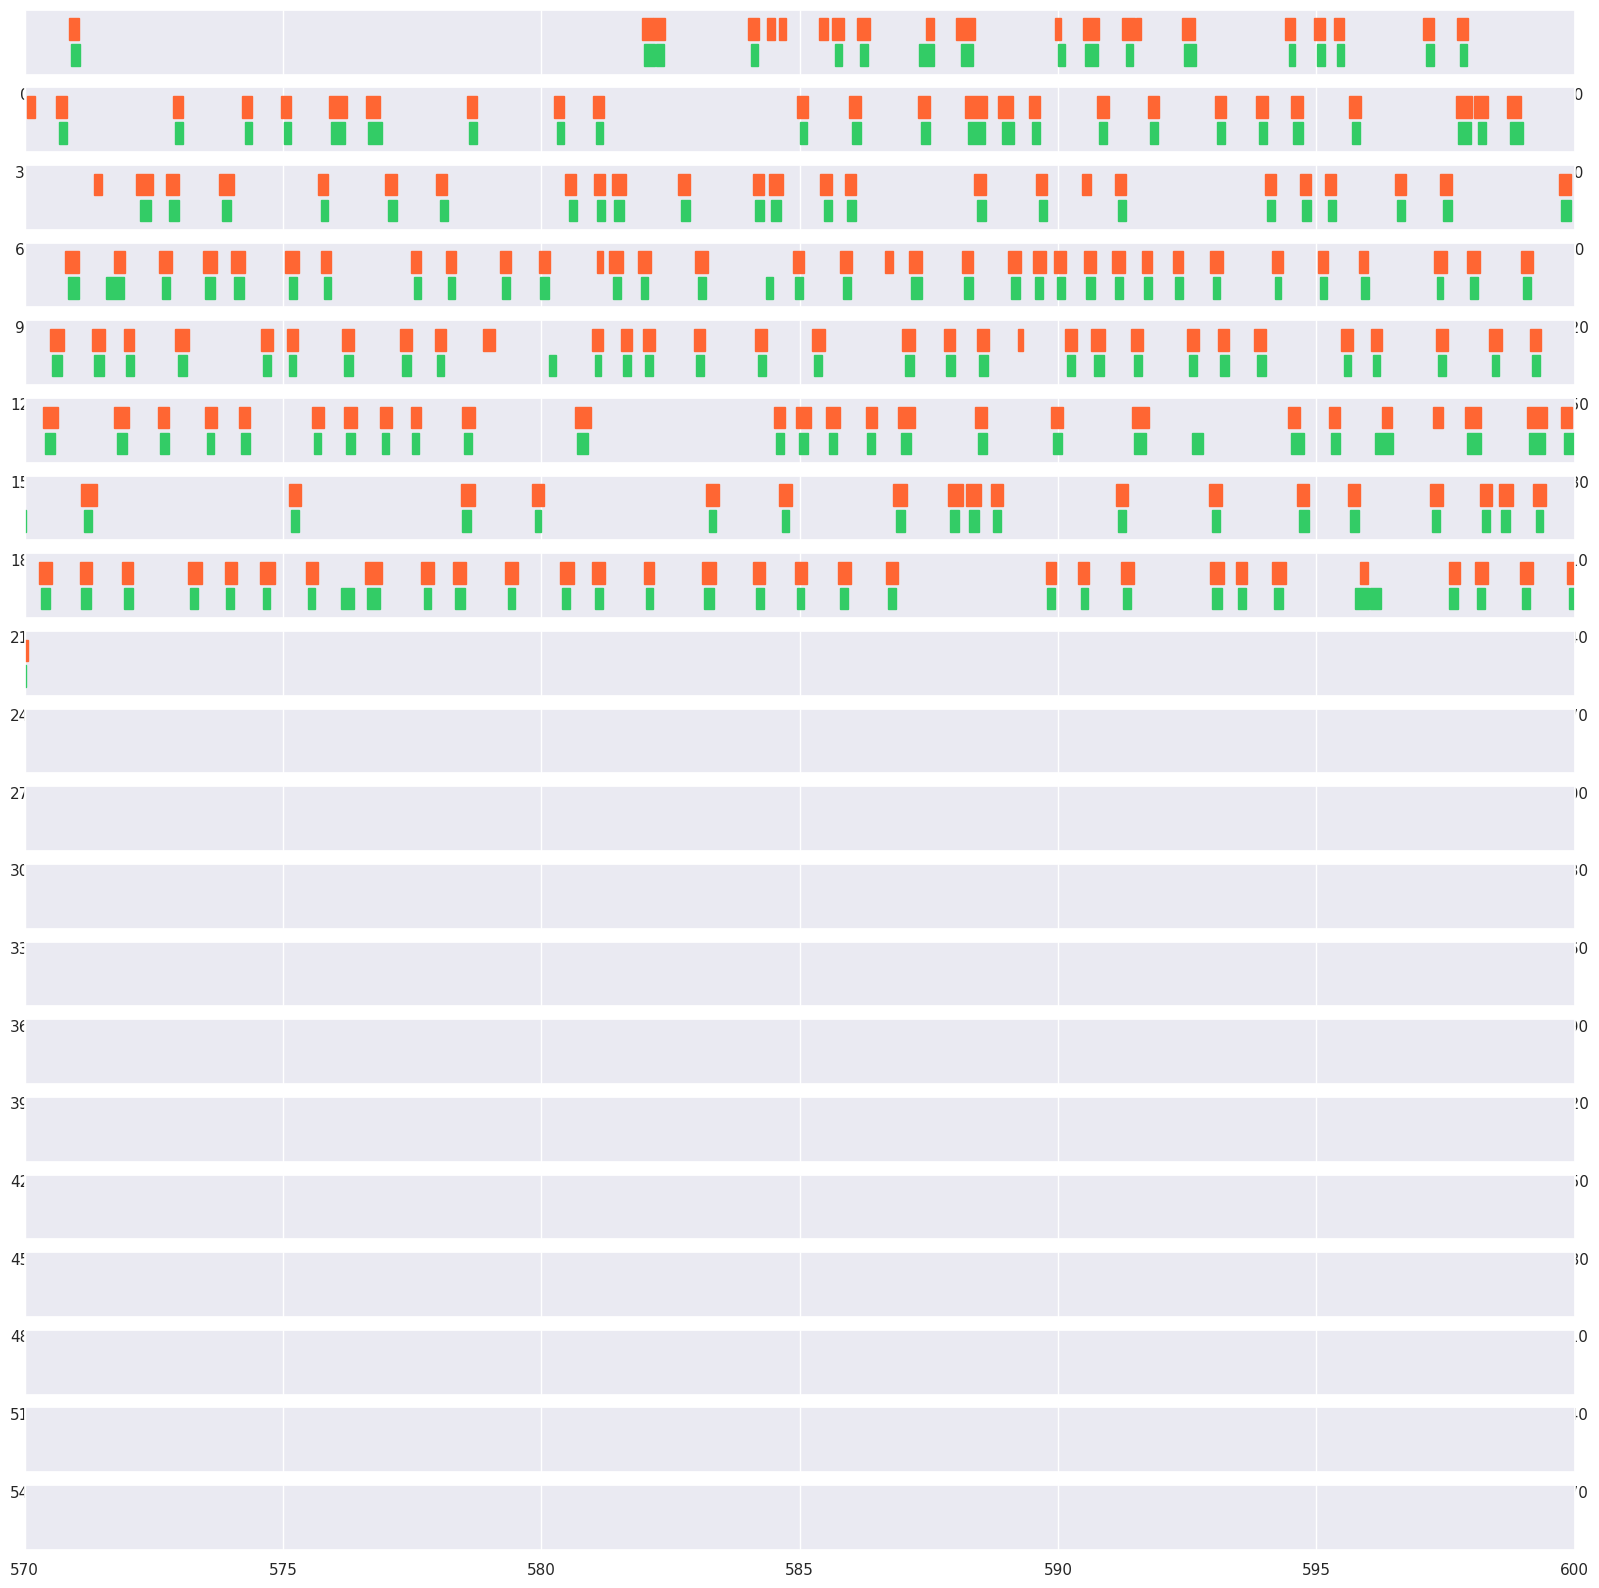

In [274]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.patches import Rectangle

def render_event_array(ax, blink_on_idx, blink_off_idx, y, color):
    # flags = np.ones(len(legend_labels))
    legends = {}

    for i in range(len(blink_on_idx)):
        start = blink_on_idx[i]/200
        end = blink_off_idx[i]/200
        height = 0.5
        patch = Rectangle((start, y), end - start, height, color=color)
        ax.add_patch(patch)
        # legends["blink"] = patch

    ax.set_yticks([])
    ax.set_ylim(0, 1.5)

def create_subplot(ax, on_idx, off_idx, pred_on, pred_off, start, end, colors):
    render_event_array(ax, on_idx, off_idx, 0.2, color=colors[0])
    render_event_array(ax, pred_on, pred_off, 0.8, color=colors[1])
    ax.set_xlim(start, end)


blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])
predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

f, ax = plt.subplots(20, 1)
f.set_size_inches(20, 20)

colors = [[0.2, 0.8, 0.4], [1, 0.4, 0.2]]
time_intervals = [(i * 30, (i + 1) * 30) for i in range(20)]

for i, (start, end) in enumerate(time_intervals):
    create_subplot(ax[i], blink_on_idx, blink_off_idx, predicted_blink_on, predicted_blink_off, start, end, colors)


In [114]:
blink_on_idx

array([   58,   317,   664,  1549,  2771,  3985,  5193,  6450,  8802,
       10001, 10995, 11043, 13830, 14331, 15076, 15312, 16010, 16180,
       16536, 16644, 16780, 19388, 22053, 22898, 23052, 23181, 23631,
       25420, 25739, 25892, 26032, 26071, 27461, 34174, 34276, 35095,
       35658, 38738, 40672, 44049, 44462, 44553])

In [323]:
from label_mapper import label_mapping
from src.utils import resize_images

# Load each blink event
def get_confidence(start_idx, end_idx, smoothed_proba):
    """ Compute confidence for a blink event

    Parameters
    ----------
    start_idx : int
        Index of the start of the blink event
    end_idx : int
        Index of the end of the blink event
    proba : array
        Array of shape (n_samples, n_classes) containing the output of the classifier
    pp_params : dict
        Dictionary containing the parameters of the post-processing
    """

    tmp_proba = smoothed_proba[start_idx:end_idx, :]

    # find where proba[:,2] > proba[:,1] for the first time
    transition_on_off = np.where(tmp_proba[:,2] >= tmp_proba[:,1])[0][0]
    # # if is empty transition_on_off
    # if len(transition_on_off) == 0:
    #     transition_on_off = (end_idx-start_idx) // 2
    # else:    
    #     transition_on_off = transition_on_off[0]

    # compute average proba for left of transition
    confidence_onset = np.mean(tmp_proba[:transition_on_off, 1])
    # compute average proba for right of transition
    confidence_offset = np.mean(tmp_proba[transition_on_off:, 2])
    # combine confidences for blink confidence  
    confidence_blink = (confidence_onset + confidence_offset)/2

    return confidence_blink, confidence_onset, confidence_offset

def find_ts_index(ts, t):
    """ Find index of a timestamp in a list of timestamps

    Parameters
    ----------
    ts : array
        Array of timestamps
    t : float
        Timestamp to find
    """
    
    return np.where(ts == t)[0][0]

def get_blink_events(iclip):
    """ Load a recording and return the timestamps, images and blink events
    
    Returns
    -------
    ts : array
    
    """

    of_params, pp_params = get_params()
    aug_params = AugParams()
    of_params.n_layers = 5
    of_params.layer_interval = 7
    of_params.grid_size = 4
    of_params.window_size = 15

    clf = get_classifier("/users/tom/git/neon_blink_detection/weights/xgb.sav")

    rec = video_loader(of_params, aug_params)
    ts, images_left, images_right = rec._get_frames_pyav(clip_names[iclip], convert_to_gray=True)

    blink_df = rec._load_gt_labels(clip_names[iclip])

    grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
    images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

    feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

    features = concatenate_features(feature_array, of_params)
    proba = clf.predict_proba(features)
    blink_events = post_process(ts, proba, pp_params)


    left_images, right_images = resize_images(
        images_left, images_right, img_shape=(64, 64)
    )

    blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
    blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
    blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
    blink_off_idx = np.where(np.isin(ts, blink_ts))[0]
    
    predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

    predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

    pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

    gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

    return pred, gt, proba, left_images, right_images

# def classify(proba: np.ndarray, pp_params: PPParams) -> np.ndarray:
#     pd_labels = np.argmax(proba, axis=1)

#     pd_labels[
#         (proba[:, 1] > pp_params.proba_onset_threshold) & (proba[:, 2] > pp_params.proba_offset_threshold) & (proba[:, 1] > proba[:, 2])
#     ] = label_mapping.onset

#     pd_labels[
#         (proba[:, 1] > pp_params.proba_onset_threshold) & (proba[:, 2] > pp_params.proba_offset_threshold) & (proba[:, 1] < proba[:, 2])
#     ] = label_mapping.offset

#     return pd_labels

def classify(proba: np.ndarray, pp_params: PPParams) -> np.ndarray:
    pd_labels = np.argmax(proba, axis=1)
    pd_labels[
        proba[:, label_mapping.offset] > pp_params.proba_offset_threshold
    ] = label_mapping.offset
    pd_labels[
        proba[:, label_mapping.onset] > pp_params.proba_onset_threshold
    ] = label_mapping.onset
    return pd_labels



In [347]:
confidence_blink = []
confidence_blink_fp = []
confidence_probas_tp = []
# also save all probas for the false positives
confidence_probas_fp = []
confidence_blink_tp = []
confidence_li_fp = []
confidence_ri_fp = []
confidence_li_tp = []
confidence_ri_tp = []

for iclip in range(len(clip_names)):

    print("Processing clip {}".format(iclip))

    pred_blink, gt_blinks, proba, li, ri = get_blink_events(iclip)
    smoothed_proba = smooth_proba(proba, pp_params)
    iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt_blinks, pred_blink)

    # print number of false positives 
    print("Number of false positives: {}".format(len(false_positives)))

    for i in range(len(true_positives)):

        start_idx = true_positives[i][1][0]
        end_idx = true_positives[i][1][1]
        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
        confidence_blink.append(confidence_blink_tmp)
        confidence_probas_tp.append(smoothed_proba[start_idx:end_idx, :])  
        confidence_li_tp.append(li[start_idx:end_idx, :, :])
        confidence_ri_tp.append(ri[start_idx:end_idx, :, :])


    for i in range(len(false_positives)):

        start_idx = false_positives[i][1][0]
        end_idx = false_positives[i][1][1]
        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
        confidence_blink_fp.append(confidence_blink_tmp)
        confidence_probas_fp.append(smoothed_proba[start_idx:end_idx, :])
        confidence_li_fp.append(li[start_idx:end_idx, :, :])
        confidence_ri_fp.append(ri[start_idx:end_idx, :, :])

Processing clip 0
Number of false positives: 12
Processing clip 1


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 3
Processing clip 2


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 21
Processing clip 3
Number of false positives: 2
Processing clip 4
Number of false positives: 4
Processing clip 5


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 8
Processing clip 6


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 0
Processing clip 7


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 7
Processing clip 8


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 2


(0.0, 10.0)

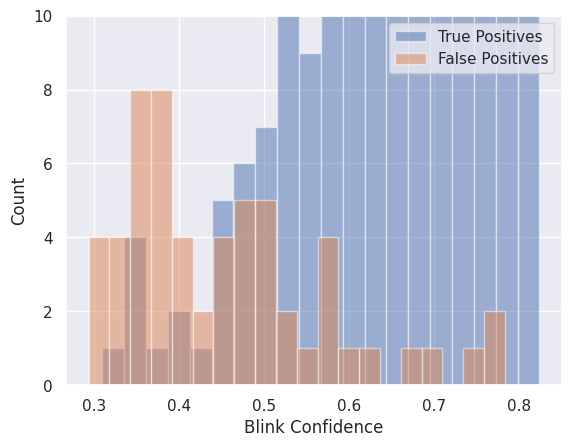

In [365]:
# same as above, but normalize the two histograms to the same area
fig, ax = plt.subplots(1, 1)
ax.hist(confidence_blink, bins=20, alpha=0.5, label="True Positives", density=False)
ax.hist(confidence_blink_fp, bins=20, alpha=0.5, label="False Positives", density=False)
ax.set_xlabel("Blink Confidence")
ax.set_ylabel("Count")
ax.legend(loc="upper right")
ax.set_ylim(0, 10)

In [352]:
# sort confidence_blink from low to high and return also the indices of the sorted array
confidence_blink_sorted = np.sort(confidence_blink)
confidence_blink_sorted_idx = np.argsort(confidence_blink)



array([429, 970, 782, ..., 807,   2, 951])

In [364]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

index = confidence_blink_sorted_idx[11]

print(confidence_blink[index])

fig, axs = plt.subplots(2, 2)

video_left = confidence_li_tp[index]
video_right = confidence_ri_tp[index]

fig.set_size_inches(8, 6)
im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
axs[0, 0].axis("off")
axs[0, 1].axis("off")

plt.close() # this is required to not display the generated image

# plot proba output of the classifier for the false positive event
axs[1, 0].plot(confidence_probas_tp[index])
axs[1, 0].set_xlabel("Frame")
axs[1, 0].set_ylabel("Probability")
# legend
axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

axs[1, 1].axis("off")

def init():
    im0.set_data(video_left[0,:,:])
    im1.set_data(video_right[0,:,:])

def animate(frame):
    im0.set_data(video_left[frame,:,:])
    im1.set_data(video_right[frame,:,:])

    return im0, im1

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

anim.save('/users/tom/blink_videos/false_positive_example_%.2f.mp4' %(confidence_blink[index]), extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())

0.4608573913574219


In [332]:
import imageio
# make video from numpy array, where first dimension are the frames and second dimensonsare the image
def make_video_from_array(array, filename, fps=30):
    writer = imageio.get_writer(filename, fps=fps)
    for i in range(array.shape[0]):
        writer.append_data(array[i, :, :])
    writer.close()

make_video_from_array(confidence_li_fp[max_conf_fp], "false_positive.mp4")

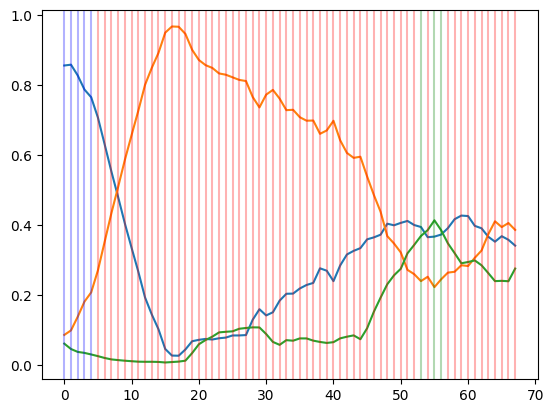

In [234]:
labels = classify(smoothed_proba, pp_params)

plt.plot(smoothed_proba[start_idx-20:end_idx+20, :])

# for the range from start_idx to end_idx
counter = 0

for i in range(start_idx-20, end_idx+20):
    # if the label is onset
    if labels[i] == label_mapping.onset:
        # plot a red vertical line
        plt.axvline(x=counter, color='r', alpha=0.3)
    # if the label is offset
    elif labels[i] == label_mapping.offset:
        # plot a blue vertical line
        plt.axvline(x=counter, color='g', alpha=0.3)
    # if the label is blink
    elif labels[i] == label_mapping.bg:
        # plot a green vertical line
        plt.axvline(x=counter, color='b', alpha=0.3)
    
    counter += 1


In [235]:
pp_params

PPParams(max_gap_duration_s=0.03, short_event_min_len_s=0.1, smooth_window=11, proba_onset_threshold=0.25, proba_offset_threshold=0.25)

In [290]:
# loop through all predicted blinks and obtain the labels for each blink

labels = classify(smoothed_proba, pp_params)

labels_pred = []
for i in range(len(pred_blink)):
    start_idx = pred_blink[i][0]
    end_idx = pred_blink[i][1]
    labels_pred.append(labels[start_idx:end_idx])



True

In [239]:
start_idx = true_positives[i][1][0]
end_idx = true_positives[i][1][1]

tmp_proba = smoothed_proba[start_idx:end_idx, :]

# find where proba[:,2] > proba[:,1] for the first time
transition_on_off = np.where(tmp_proba[:,2] >= tmp_proba[:,1])[0]
# if is empty transition_on_off
# if len(transition_on_off) == 0:
#     transition_on_off = (end_idx-start_idx) // 2
# else:    
#     # compute average proba for left of transition
#     confidence_onset = np.mean(tmp_proba[:transition_on_off, 1])
#     # compute average proba for right of transition
#     confidence_offset = np.mean(tmp_proba[transition_on_off:, 2])
#     # combine confidences for blink confidence  
#     confidence_blink = (confidence_onset + confidence_offset)/2


In [248]:
np.where(tmp_proba[:,2] >= tmp_proba[:,1])[0]

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34])

In [297]:
iclip = 0

pred_blink, gt_blinks, proba = get_blink_events(iclip)
smoothed_proba = smooth_proba(proba, pp_params)
iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt_blinks, pred_blink, iou_threshold=0.2)

# print number of false positives 
print("Number of false positives: {}".format(len(false_positives)))



Number of false positives: 12


In [280]:
confidence_blink_fp = []
confidence_blink = []

for i in range(len(true_positives)):

    start_idx = true_positives[i][1][0]
    end_idx = true_positives[i][1][1]
    confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
    confidence_blink.append(confidence_blink_tmp)

for i in range(len(false_positives)):

    start_idx = false_positives[i][1][0]
    end_idx = false_positives[i][1][1]
    confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
    confidence_blink_fp.append(confidence_blink_tmp)

/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [282]:
confidence_blink

[0.665640652179718,
 0.5407285094261169,
 nan,
 0.6329396367073059,
 0.6884862184524536,
 0.7460964322090149,
 0.5444397330284119,
 nan,
 0.6386624574661255,
 0.48403996229171753,
 0.5172744989395142,
 0.6404839158058167,
 0.5816142559051514,
 0.629212498664856,
 0.6938033103942871,
 0.6743751168251038,
 0.6130296587944031,
 0.7129703760147095,
 0.5448940396308899,
 0.6492363214492798,
 0.6442983150482178,
 0.6220530867576599,
 0.5600031614303589,
 0.6080862283706665,
 0.5410023927688599,
 0.5769480466842651,
 0.5854050517082214,
 0.6442569494247437,
 0.6323896646499634,
 0.6595690250396729,
 0.6218774318695068,
 0.6625593304634094,
 0.6797127723693848,
 0.7188701629638672,
 0.607954740524292,
 0.6240642070770264,
 0.6999142169952393,
 0.7209187746047974,
 0.4905126690864563,
 0.7487220168113708,
 0.5344855785369873,
 0.6721424460411072,
 0.6534684300422668,
 0.7423206567764282,
 0.6621284484863281,
 0.7134592533111572,
 0.6722984910011292,
 0.5490432381629944,
 0.6789345741271973,
 0.

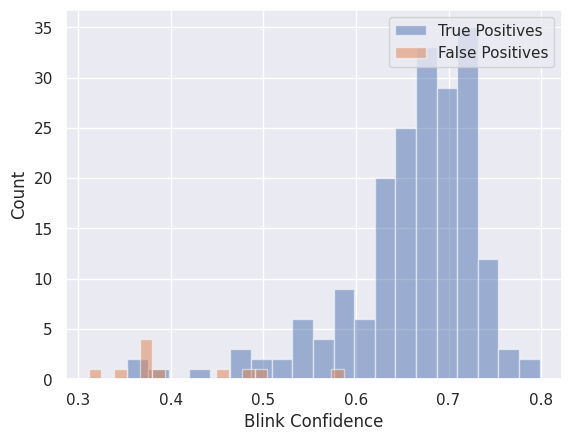

In [283]:
# same as above, but normalize the two histograms to the same area
fig, ax = plt.subplots(1, 1)
ax.hist(confidence_blink, bins=20, alpha=0.5, label="True Positives", density=False)
ax.hist(confidence_blink_fp, bins=20, alpha=0.5, label="False Positives", density=False)
ax.set_xlabel("Blink Confidence")
ax.set_ylabel("Count")
ax.legend(loc="upper right")
